In [9]:
pip install pdfminer install pdfminer.six PyPDF2 gensim wordcloud pdfplumber


Note: you may need to restart the kernel to use updated packages.


In [2]:
#Importing relevant libraries
from pdfminer.high_level import extract_text
import PyPDF2
from PyPDF2 import PdfReader
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import download
from gensim import corpora, models
from gensim.models import CoherenceModel
import os
import statistics
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import pearsonr
import matplotlib.pyplot
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from gensim.models.coherencemodel import CoherenceModel
import tensorflow as tf
import os
import pdfplumber
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from gensim.corpora import Dictionary
from gensim.models import HdpModel



# Download other resources
download('stopwords')
download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
#Initial stats - file count

def count_files_in_folder(folder_path):
    # Initialize a counter for files
    file_count = 0

    # Walk through the directory and count files
    for _, _, files in os.walk(folder_path):
        file_count += len(files)

    return file_count

folder_path = '/notebooks/CIND820/Dataset_Sample_385'
total_files = count_files_in_folder(folder_path)
print("Total files in datasource: ", total_files)

Total files in datasource:  385


In [4]:
#Initial stats - page count

def count_pages_and_stats(folder_path):
    total_pages = 0
    page_counts = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.pdf'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'rb') as file:
                pdf_reader = PdfReader(file)
                num_pages = len(pdf_reader.pages)
                total_pages += num_pages
                page_counts.append(num_pages)

    mean_page_count = statistics.mean(page_counts)
    median_page_count = statistics.median(page_counts)

    return total_pages, mean_page_count, median_page_count

folder_path = '/notebooks/CIND820/Dataset_Sample_385'
total_pages, mean_page_count, median_page_count = count_pages_and_stats(folder_path)

print("Total pages in all PDF files:", total_pages)
print("Mean page count per file:", mean_page_count)
print("Median page count per file:", median_page_count)

Total pages in all PDF files: 30365
Mean page count per file: 79.07552083333333
Median page count per file: 80.0


In [5]:
# Function for preprocessing text
def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text)
    # Remove punctuation and convert to lowercase
    tokens = [token.lower() for token in tokens if token.isalpha()]
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    french_stopwords = set(stopwords.words('french'))
    stop_words.update(french_stopwords)
    # Remove specific words or letters which are not useful
    additional_stopwords = [
        'mr.', 'mr', 'mrs.', 'ms.', 'speaker', 'bill', 'debate', 'hon', 'cpc', 'lib', 'bq', 'canadian', 
        'act', 'amend', 'amendment', 'canada', 'house', 'public', 'honour', 'minister', 'ministry', 'govern', 
        'member', 'program', 'primeminister', 'would', 'people', 'chair', 'committe', 'liber', 'polici', 'parliamentari', 
        'ndp', 'government', 'conserv', 'parties', 'partisan', 's', 'b', 'c', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
        'q', 'r', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'am', 'pm','year','time','motion','go', 'canadians', 
        'also', 'members', 'madam', 'committee', 'prime', 'senate', 'senator', 'hous',
        'one', 'govern', 'liberal', 'conservative', 'liberals', 'conservatives', 'speech', 'parliamentarian',
        'secretariat', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'xi', '000', '1', '3', '5', '11', 
        '15', '22', '25', '2007', '2008', '2009', '2010', '2011',
        '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '‚Äô',
        '‚Äú', '‚Äù', "’",'...................',' ................................................',
        '........',"'s"]
    stop_words.update(additional_stopwords)
    tokens = [token for token in tokens if token not in stop_words]
    # Remove numbers, symbols, and certain words
    tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens]
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

# Directory path containing PDF files
pdf_directory = '/notebooks/CIND820/Dataset_Sample_385'

# List all PDF files in the directory
pdf_files = [os.path.join(pdf_directory, file) for file in os.listdir(pdf_directory) if file.endswith('.pdf')]

texts = []

# Loop through each PDF file and extract text
for pdf_file in pdf_files:
    with pdfplumber.open(pdf_file) as pdf:
        text = ""
        for page in pdf.pages:
            text += page.extract_text()
        texts.append(text)

# Preprocess text
preprocessed_texts = [preprocess_text(text) for text in texts]

# Create a dictionary from the preprocessed text
dictionary = Dictionary(preprocessed_texts)

# Create a corpus
corpus = [dictionary.doc2bow(text) for text in preprocessed_texts]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import logging

# Set up logging to see the progress
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Create a range of topics to cross-validate
start_topics = 2
limit_topics = 40
step_topics = 1
topics_range = range(start_topics, limit_topics + 1, step_topics)

# Cross-validate number of topics
coherence_scores = []

for num_topics in topics_range:
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=preprocessed_texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_lda)

2024-03-31 04:34:45,062 : INFO : using symmetric alpha at 0.5
2024-03-31 04:34:45,063 : INFO : using symmetric eta at 0.5
2024-03-31 04:34:45,128 : INFO : using serial LDA version on this node
2024-03-31 04:34:45,248 : INFO : running online (multi-pass) LDA training, 2 topics, 15 passes over the supplied corpus of 384 documents, updating model once every 384 documents, evaluating perplexity every 384 documents, iterating 50x with a convergence threshold of 0.001000
2024-03-31 04:34:53,951 : INFO : -14.080 per-word bound, 17316.4 perplexity estimate based on a held-out corpus of 384 documents with 7865703 words
2024-03-31 04:34:53,952 : INFO : PROGRESS: pass 0, at document #384/384
2024-03-31 04:34:57,253 : INFO : topic #0 (0.500): 0.004*"work" + 0.003*"make" + 0.003*"like" + 0.003*"need" + 0.003*"order" + 0.003*"want" + 0.003*"question" + 0.002*"support" + 0.002*"right" + 0.002*"commonsdeb"
2024-03-31 04:34:57,260 : INFO : topic #1 (0.500): 0.004*"work" + 0.004*"need" + 0.003*"support"

In [10]:
# Display coherence scores by the number of topics
print("Coherence Scores by Number of Topics:")
for num_topics, coherence_score in zip(topics_range, coherence_scores):
    print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_score}")

Coherence Scores by Number of Topics:
Number of Topics: 2, Coherence Score: 0.2953050389397854
Number of Topics: 3, Coherence Score: 0.3023040651353146
Number of Topics: 4, Coherence Score: 0.45667427373625546
Number of Topics: 5, Coherence Score: 0.2856457082541316
Number of Topics: 6, Coherence Score: 0.445946435501327
Number of Topics: 7, Coherence Score: 0.36366520396623275
Number of Topics: 8, Coherence Score: 0.3631482496151484
Number of Topics: 9, Coherence Score: 0.38606434470033274
Number of Topics: 10, Coherence Score: 0.3357637355205216
Number of Topics: 11, Coherence Score: 0.3126368269768181
Number of Topics: 12, Coherence Score: 0.3710284661941117
Number of Topics: 13, Coherence Score: 0.3347028609072971
Number of Topics: 14, Coherence Score: 0.3206697143446566
Number of Topics: 15, Coherence Score: 0.3552410709671824
Number of Topics: 16, Coherence Score: 0.36770682369839375
Number of Topics: 17, Coherence Score: 0.33508163606217806
Number of Topics: 18, Coherence Score:

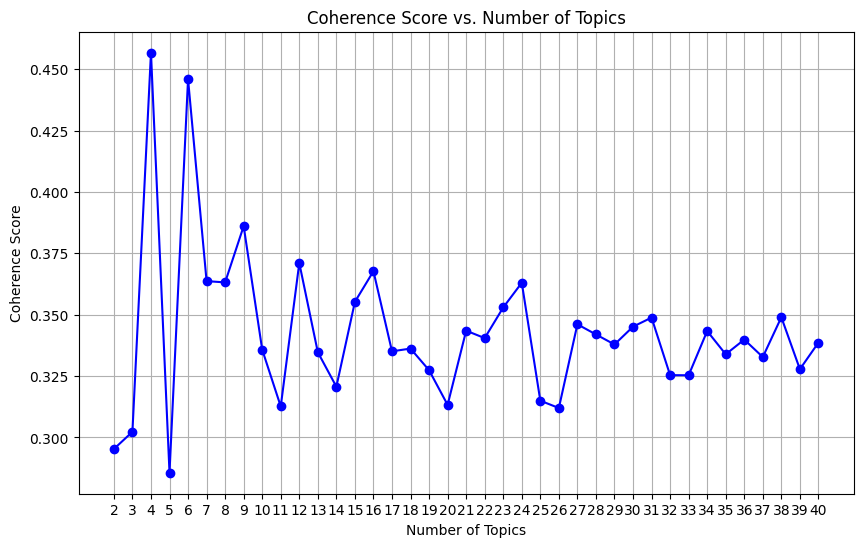

In [12]:
# Increase figure size
plt.figure(figsize=(10, 6))


# Plot coherence scores against the number of topics
plt.plot(topics_range, coherence_scores, marker='o', color='b')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.xticks(topics_range)
plt.grid()
plt.show()